In [1]:
DATA_PATH = '../data/coco/data/'
img_codes_path = DATA_PATH + 'image_codes.npy'
captions_path = DATA_PATH + 'captions_tokenized.json'

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_padded_sequence

from image_captioning.utils import Vocab, create_datasets, pad_collate_fn
from image_captioning.models import AttentionDecoder

In [3]:
vocab = Vocab(captions_path)
datasets = create_datasets(vocab, img_codes_path, captions_path)
train, val, test = datasets['train'], datasets['val'], datasets['test']

In [4]:
batch_size = 4

train_loader = DataLoader(train, batch_size, num_workers=4, collate_fn=pad_collate_fn)
val_loader = DataLoader(val, batch_size, num_workers=4, collate_fn=pad_collate_fn)
test_loader = DataLoader(test, batch_size, num_workers=4, collate_fn=pad_collate_fn)

In [8]:
imgs_ids = list(range(len(val_loader) * batch_size))
references = {img_id: caps for (img_id, caps)
              in zip(imgs_ids, val.captions)}
# here we will store predictions
hypotheses = {img_id: [] for img_id in imgs_ids}  
for i, (imgs, captions, lenghts) in enumerate(val_loader):
    imgs = imgs.to(device)
    captions = captions.to(device)
    decode_lenght = max(lenghts - 1)
    
    loss = 0
    hidden = imgs
    decoder_input = captions[:, 0]
    for step in range(decode_lenght):
        logits, hidden = model(imgs, decoder_input, hidden)
        decoder_input = logits.argmax(dim=1)
        
        imgs_ids = [id + i * batch_size for id in range(batch_size)]
        output = decoder_input.cpu().numpy()
        for img_id, token in zip(imgs_ids, output):
            string = vocab.itos(int(token))
            if string not in ['<eos>', '<pad>']:
                hypotheses[img_id].append(string)
                
        targets = captions[:, step + 1]
        loss += criterion(logits, targets)
#         print(decoder_input)
#         print(vocab.itos(list(decoder_input.cpu().numpy())))

In [9]:
for id in hypotheses.keys():
    str_list = []
    str_list.append(' '.join(hypotheses[id]))
    hypotheses[id] = str_list

In [11]:
len(references)

5000

In [6]:
torch.backends.cudnn.benchmark = True
###################
hidden_size = 512
num_layers = 2
dropout = 0.15
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu'
)
###################

model = AttentionDecoder(
    vocab=vocab,
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout=dropout,
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.AdamW(model.parameters())

No handles with labels found to put in legend.


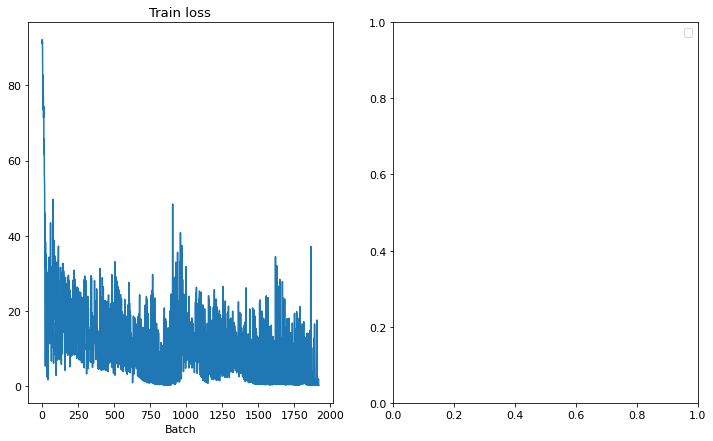

KeyboardInterrupt: 

In [10]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'figure.figsize': (12, 7), 'font.size': 11})
from IPython.display import clear_output

train_history = None
valid_history = None
imgs, captions, lenghts = next(iter(train_loader))
clip = 5
history = []
for i in range(2000):
    model.train()
    
    epoch_loss = 0
    
    imgs = imgs.to(device)
    captions = captions.to(device)
    caption_lenghts, sorted_idx = lenghts.sort(descending=True)
    imgs = imgs[sorted_idx]
    captions = captions[sorted_idx]
    decode_lenghts = caption_lenghts - 1
    
    loss = 0
    hidden = imgs.clone()
    imgs_input = imgs.clone()
    decoder_input = captions[:, 0]
    for step in range(max(decode_lenghts)):
#         print(f'dec_inp {decoder_input.shape}')
        logits, hidden = model(imgs_input, decoder_input, hidden)
#         print(f'logits {logits.shape}')
        decoder_input = logits.argmax(dim=1)
        
        non_eos_idx = (decoder_input != vocab.stoi('<eos>')).nonzero(as_tuple=False).view(-1)
#         print(f'non_eos {non_eos_idx}')
        if non_eos_idx.shape[0] == 0:
            break
        decoder_input = decoder_input[non_eos_idx]
        imgs_input = imgs_input[non_eos_idx]
        targets = captions[non_eos_idx][:, step + 1]
        hidden = hidden[non_eos_idx]
#         print(logits[non_eos_idx].shape)
#         print(captions[non_eos_idx][:, step+1].shape)
        loss += criterion(logits[non_eos_idx], targets)
        print('\n\n')

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()

#     print(loss.item())
#     clear_output(True)
    epoch_loss += loss.item()
    history.append(loss.cpu().data.numpy())
    if (i+1)%10==0:
        print(loss)
        fig, ax = plt.subplots(nrows=1, ncols=2)

        clear_output(True)
        ax[0].plot(history, label='train loss')
        ax[0].set_xlabel('Batch')
        ax[0].set_title('Train loss')
        if train_history is not None:
            ax[1].plot(train_history, label='general train history')
            ax[1].set_xlabel('Epoch')
        if valid_history is not None:
            ax[1].plot(valid_history, label='general valid history')
        plt.legend()
        
        plt.show()

In [41]:
from pycocoevalcap.cider.cider import Cider 
from pycocoevalcap.bleu.bleu import Bleu

In [42]:
cider = Cider(df='corpus')
bleu = Bleu(n=4)

In [147]:
ref = {132: ['train is traveling down the road', 'train travels down the road'], 4: ['a cat in a black tie', 'cat in the black tie']}
hypo = {132: ['train traveling down the road'], 4: ['a cat in black tie']}
# print(cider.compute_score(ref, hypo))
bleu.compute_score(ref, hypo)[0][3]

0.553340959706062

In [44]:
cider.compute_score(ref, hypo)[0]

4.609551677054663